### Описание задания

Приблизить стационарный и не стационарный ряды моделями из класса Moving Average.
Обосновать критерии выбора моделей для рядов и оценить качество выбранных моделей.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

Из прошлого проекта [Introducing_in_time_series](../1_Introducing_in_time_series/introducing_in_time_series.ipynb) выберем один стационарный датасет и один нестационарный с трендом и сезонностью. 

In [2]:
airlines_passengers = pd.read_csv('../Data/international-airline-passengers.csv')
female_births = pd.read_csv('../Data/daily-total-female-births-in-cal.csv')

**Описание датасетов:**
- airlines_passengers - International airline passengers: monthly totals in thousands: нестационарный временной ряд с трендом сезонностью
- female_births - Daily total female births in California: стационарный временной ряд

### Необходимые функции

In [26]:
# Functions for Holt-Winters' Model
def init_trend(data, season_len):
    """Initial trend"""
    return sum([float(data[season_len] - data[0]) / season_len]) / season_len

def init_seasonal_components(data, slen):
    """Initial seasonal components"""
    seasonals = {}
    season_averages = []
    n_seasons = int(len(data) / slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(data[slen*j:slen*j+slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += data[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

def triple_exponential_smoothing(data, slen, alpha, beta, gamma, n_preds):
    """Holt-Winters' Model"""
    result = []
    seasonals = init_seasonal_components(data, slen)
    for i in range(len(data) + n_preds):
        if i == 0: # initial values
            smooth = data[0]
            trend = init_trend(data, slen)
            result.append(data[0])
            continue
        if i >= len(data): # we are forecasting
            m = i - len(data) + 1
            result.append((smooth + m * trend) + seasonals[i % slen])
        else:
            val = data[i]
            last_smooth, smooth = smooth, alpha * (val - seasonals[i % slen]) + (1 - alpha) * (smooth + trend)
            trend = beta * (smooth-last_smooth) + (1 - beta) * trend
            seasonals[i % slen] = gamma * (val - smooth) + (1 - gamma) * seasonals[i % slen]
            result.append(smooth + trend + seasonals[i % slen])
    return result

def plot_tema(alpha, beta, gamma, data, n_preds=24):
    """Make plot with predict"""
    tema = triple_exponential_smoothing(data, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(data, color='blue', label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
        plt.show()

def mse_hwm(X, train, test):
    """Return mean squared error for Holt-Winters' Model"""
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

# Functions for Moving average
def moving_average(data, n):
    """Moving average"""
    if not isinstance(data, pd.Series):
        data = pd.Series(data)
    return data.rolling(n).mean()

def mse_ma(train, test, n):
    """Return mean squared error for Exponential moving average"""
    result = moving_average(train, n)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error


# Functions for Exponential moving average
def exponential_moving_average(series, alpha):
    """Exponential moving average"""
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

def mse_emv(train, test):
    """Return mean squared error for Exponential moving average"""
    result = exponential_moving_average(train, alpha=0.9)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error



### Приближение нестационарного ряда на основе International airline passengers: monthly totals in thousands

In [4]:
data = airlines_passengers['Count']

In [5]:
train, test = data[:110], data[110:]

Так как датасет содержит сезонность и тренд, единственной моделью, которая подойдёт ему будет тройное экспоненциальное сглаживание.
Выберем производьные alpha, beta и gamma в качестве первоначальных параметров.

In [6]:
alpha, beta, gamma = 0.1, 0.1, 0.2

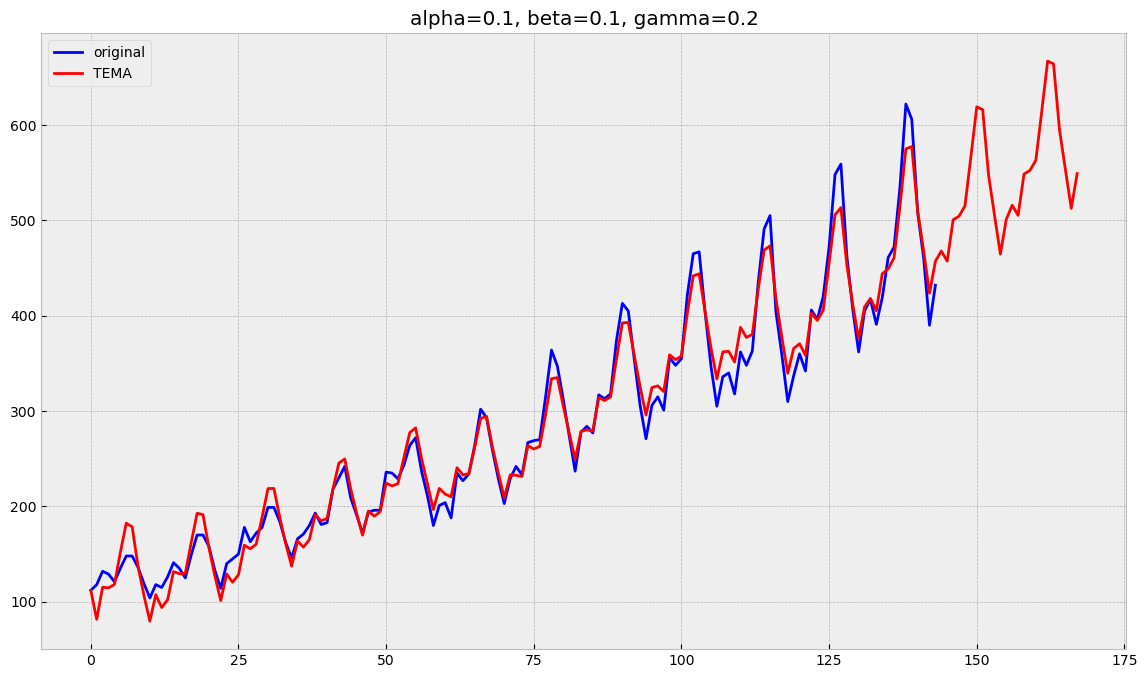

In [7]:
plot_tema(alpha, beta, gamma, data)

In [8]:
print('RMSE предсказанных значений для выбранных случайно параметров alpha, beta, gamma:',
      np.sqrt(mse_hwm([alpha, beta, gamma], train, test)))

RMSE предсказанных значений для выбранных случайно параметров alpha, beta, gamma: 35.92591408559796


Подберём отпимальные значения параметров alpha, beta, gamma

In [9]:
opt = minimize(mse_hwm, x0=[0,0,0], args=(train, test), method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [10]:
alpha_opt, beta_opt, gamma_opt = opt.x

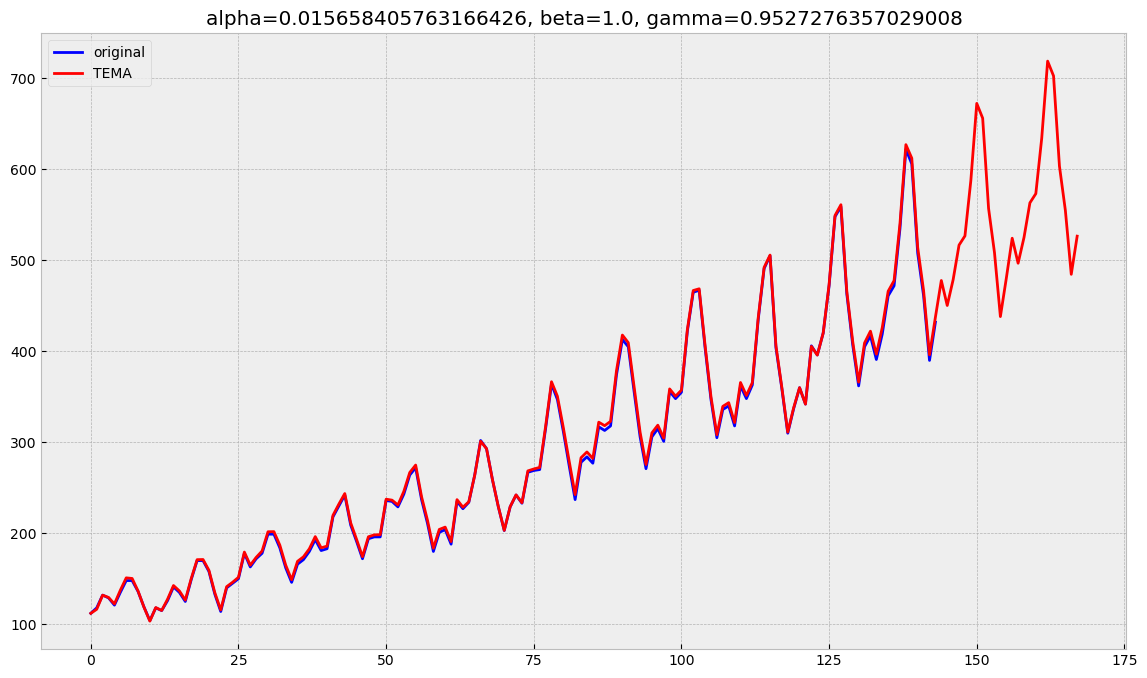

In [11]:
plot_tema(alpha_opt, beta_opt, gamma_opt, data)

In [12]:
print('RMSE предсказанных значений для подобранных параметров alpha, beta, gamma для метода Хольт-Винтерса:',
      np.sqrt(mse_hwm([alpha_opt, beta_opt, gamma_opt], train, test)))

RMSE предсказанных значений для подобранных параметров alpha, beta, gamma для метода Хольт-Винтерса: 21.959945572453595


**Вывод:** Удалось оптимально подобрать параметры для метода тройного экспоненциального сглаживания и добиться RMSE = 22

### Приближение стационарного ряда на основе Daily total female births in California

In [31]:
data = female_births['Count']

Применим метод скользящего среднего с размером "окна" 𝑛 = 7

In [32]:
n = 7

In [33]:
ser = moving_average(data, n)

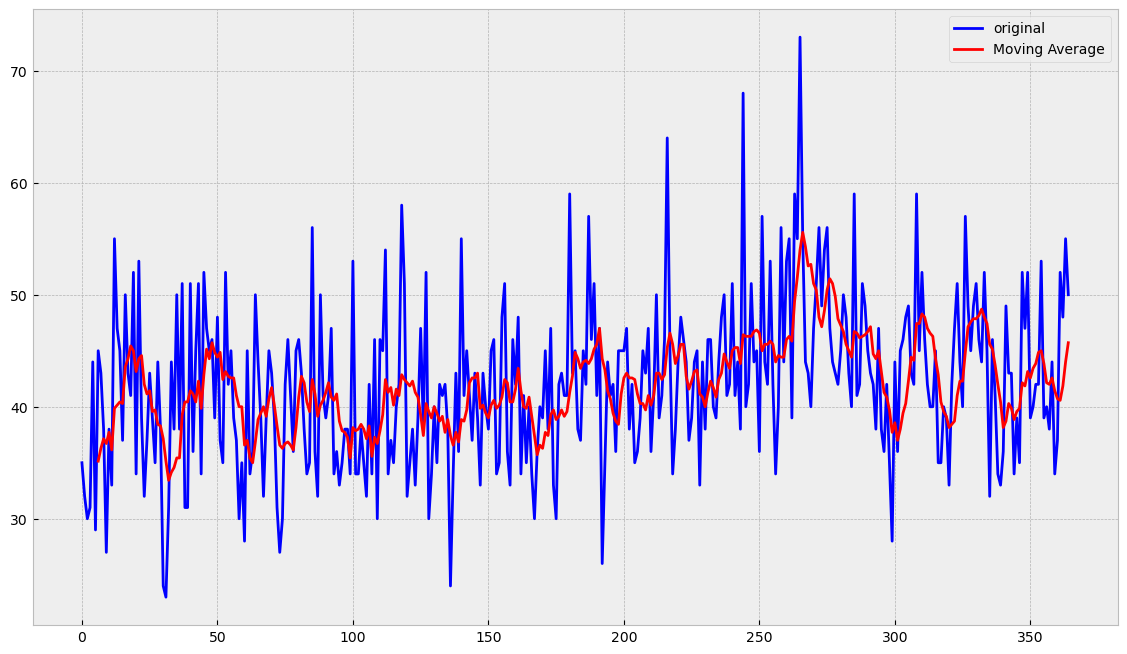

In [34]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(data, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='2', label='Moving Average')
    plt.legend()
    plt.show()

In [35]:
train, test = data[:270], data[270:]

In [36]:
print('RMSE предсказанных значений для метода скользящего среднего:',
      np.sqrt(mse_ma(train, test, n)))

RMSE предсказанных значений для метода скользящего среднего: 7.568463031095628


Применим также и метод экспотенциального сглаживания(ETA), чтобы сравнить работу методов.

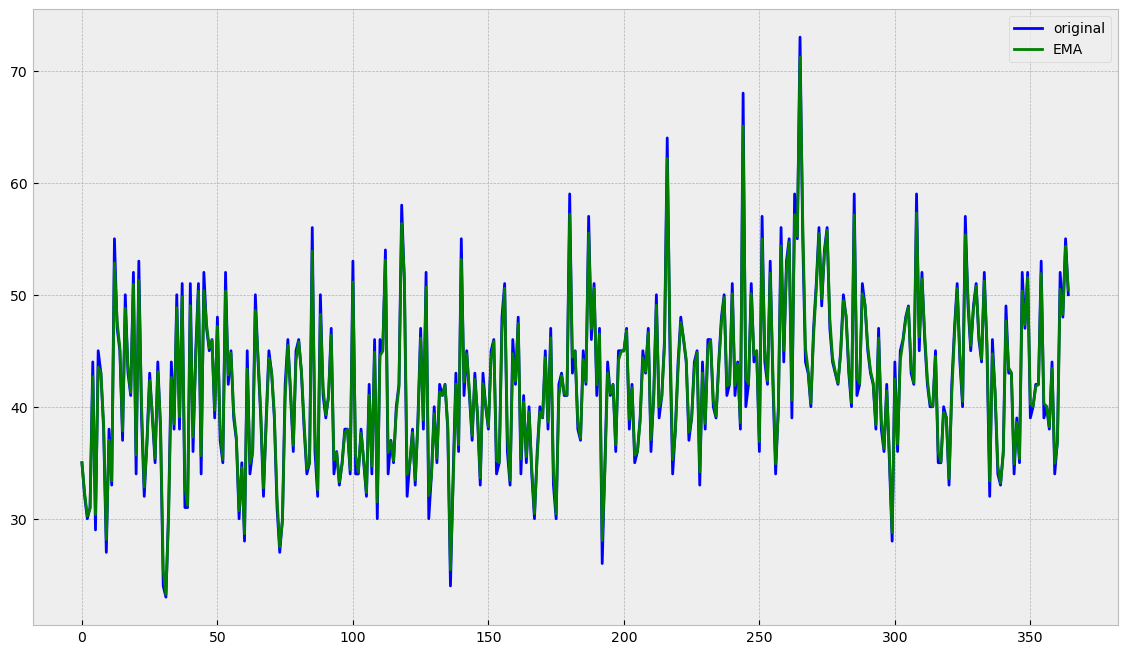

In [37]:
ema = exponential_moving_average(data, 0.9)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(data, color='blue',label='original')
    plt.plot(ema, color='green', linewidth='2', label='EMA')
    plt.legend()
    plt.show()

In [30]:
print('RMSE предсказанных значений для метода экспотенциального сглаживания:',
      np.sqrt(mse_emv(train, test)))

RMSE предсказанных значений для метода экспотенциального сглаживания: 9.86125804141042


**Вывод:** 
- для метода скользящего среднего для размера "окна" 7 получили RMSE = 7.57
- для метода экспоненциального сглаживания при alpha = 0.9 получили RMSE = 9.86

### Вывод:

В проекте были расмотрены методы скользящего среднего(MA), экспотенциального сглаживания(EMA) и тройного экспоненциального сглаживания(TEMA) для стационарного и нестационарного датасета соответственно. 